# Using Sklearn models

## Libraries

In [1]:
import numpy as np
import pandas as pd 
import os 
import sys

from geopy.distance import geodesic
from geopy.point import Point

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import gaussian_process

from tqdm.notebook import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Making Data

In [3]:
df = pd.read_csv('./data/Gopalganj_14 devices data_21 April -8 June 2023 - Gopalganj_14 devices data_21 April -29 May.csv')
df['dt_time'] = pd.to_datetime(df['dt_time'])
print(f"df.shape = {df.shape}")

df.shape = (1153, 48)


- 14 sensors

In [4]:
df.columns

Index(['dt_time', 'PM25', 'RH', 'AT', 'WS', 'WD', 'pm25_1211220109',
       'temperature_1211220109', 'humidity_1211220109', 'pm25_1212220023',
       'temperature_1212220023', 'humidity_1212220023', 'pm25_1212220165',
       'temperature_1212220165', 'humidity_1212220165', 'pm25_1212220169',
       'temperature_1212220169', 'humidity_1212220169', 'pm25_1201230044',
       'temperature_1201230044', 'humidity_1201230044', 'pm25_1210220027',
       'temperature_1210220027', 'humidity_1210220027', 'pm25_1212220159',
       'temperature_1212220159', 'humidity_1212220159', 'PM25_2CF4328C5AB4',
       'Temp_2CF4328C5AB4', 'RH_2CF4328C5AB4', 'PM25.1_2CF4328C5BAD',
       'Temp.1_2CF4328C5BAD', 'RH.1_2CF4328C5BAD', 'PM25.2_3083988F25D6',
       'Temp.2_3083988F25D6', 'RH.2_3083988F25D6', 'PM25.3_5002914AB52D',
       'Temp.3_5002914AB52D', 'RH.3_5002914AB52D', 'PM25.4_8CAAB56B9EAF',
       'Temp.4_8CAAB56B9EAF', 'RH.4_8CAAB56B9EAF', 'PM25.5_E0980690FF7B',
       'Temp.5_E0980690FF7B', 'RH.5_E0

In [5]:
num_rows_remanining = df.dropna().shape[0]
print(num_rows_remanining)

92


- dropping the rows if there are any null value and then clubbing according to the time index

In [6]:
print(f"df.shape = {df.shape}")
df.dropna(inplace=True)
print(f"df.shape = {df.shape}")

df.shape = (1153, 48)
df.shape = (92, 48)


- loading the lat and long file

In [7]:
loc = pd.read_csv('./data/Gopalganj_14 devices data_21 April -8 June 2023 - lat long.csv', index_col=0)
print(f"loc.shape = {loc.shape}")
loc.head()

loc.shape = (2, 14)


,pm25_1211220109,pm25_1212220023,pm25_1212220165,pm25_1212220169,pm25_1201230044,pm25_1210220027,pm25_1212220159,PM25_2CF4328C5AB4,PM25.1_2CF4328C5BAD,PM25.2_3083988F25D6,PM25.3_5002914AB52D,PM25.4_8CAAB56B9EAF,PM25.5_E0980690FF7B,PM25.6_F4CFA2D625EE
lat,26.461,26.269,26.468,26.465,26.389,26.589,26.369,26.446,26.346,26.400,26.558,26.431,26.572,26.446
long,84.247,84.746,84.448,83.990,84.588,84.154,84.314,84.115,84.696,84.492,84.331,84.396,84.080,84.287


In [8]:
lat_list = loc.iloc[0, :].tolist()
long_list = loc.iloc[1, :].tolist()

In [9]:
df.columns

Index(['dt_time', 'PM25', 'RH', 'AT', 'WS', 'WD', 'pm25_1211220109',
       'temperature_1211220109', 'humidity_1211220109', 'pm25_1212220023',
       'temperature_1212220023', 'humidity_1212220023', 'pm25_1212220165',
       'temperature_1212220165', 'humidity_1212220165', 'pm25_1212220169',
       'temperature_1212220169', 'humidity_1212220169', 'pm25_1201230044',
       'temperature_1201230044', 'humidity_1201230044', 'pm25_1210220027',
       'temperature_1210220027', 'humidity_1210220027', 'pm25_1212220159',
       'temperature_1212220159', 'humidity_1212220159', 'PM25_2CF4328C5AB4',
       'Temp_2CF4328C5AB4', 'RH_2CF4328C5AB4', 'PM25.1_2CF4328C5BAD',
       'Temp.1_2CF4328C5BAD', 'RH.1_2CF4328C5BAD', 'PM25.2_3083988F25D6',
       'Temp.2_3083988F25D6', 'RH.2_3083988F25D6', 'PM25.3_5002914AB52D',
       'Temp.3_5002914AB52D', 'RH.3_5002914AB52D', 'PM25.4_8CAAB56B9EAF',
       'Temp.4_8CAAB56B9EAF', 'RH.4_8CAAB56B9EAF', 'PM25.5_E0980690FF7B',
       'Temp.5_E0980690FF7B', 'RH.5_E0

In [10]:
# preparing the data:
my_dict = {}
sensor_names = []

for j in range(df.shape[0]):

    data = pd.DataFrame(columns=['sensor_pm25', 'sensor_temp', 'sensor_rh', 'sensor_lat', 'sensor_long'])

    for i in range(14):
        # looping over the column of df
        sensor_pm_index = int(3*(i+1) + 3)
        if j == 0:
            sensor_names.append(df.columns[sensor_pm_index])
        loc_index = int(i)
        sensor_temp_index = int(sensor_pm_index + 1)
        sensor_rh_index = int(sensor_pm_index + 2)
        
        row = {'sensor_pm25': df.iloc[j, sensor_pm_index], 'sensor_temp': df.iloc[j, sensor_temp_index], 'sensor_rh': df.iloc[j, sensor_rh_index],
               'sensor_lat': lat_list[loc_index], 'sensor_long': long_list[loc_index]}
        # data = data.append(row, ignore_index=True)
        data.loc[i] = row.values()
        # print(f"data.shape = {data.shape}")

    my_dict[str(df.iloc[j, 0])] = data

In [11]:
my_dict['2023-01-05 13:00:00']

,sensor_pm25,sensor_temp,sensor_rh,sensor_lat,sensor_long
0,73.000000,30.000000,57.000000,26.461,84.247
1,97.500000,27.000000,70.000000,26.269,84.746
2,84.000000,32.000000,54.000000,26.468,84.448
3,52.500000,36.500000,43.000000,26.465,83.990
4,102.500000,29.500000,64.000000,26.389,84.588
5,77.500000,32.000000,54.000000,26.589,84.154
6,69.000000,32.500000,51.500000,26.369,84.314
7,56.440000,31.544000,55.052000,26.446,84.115
8,57.120690,37.746552,31.862069,26.346,84.696
9,57.333333,33.585000,40.588333,26.400,84.492


In [12]:
def calculate_distance(lat1, long1, lat2, long2):

    ''' 
    calculates and returns the distance between two locations in kilometers
    '''

    location1 = Point(lat1, long1)
    location2 = Point(lat2, long2)

    distance = geodesic(location1, location2).kilometers
    return distance

In [13]:
# preparing the target and the input by leaving one sensor out each time for a fixed time and then making (X, y)
for my_key in my_dict.keys():

    data = my_dict[my_key]

    # start leaving one out and then calculate the distance 
    columns_to_use = ['sensor_pm25', 'sensor_temp', 'sensor_rh', 'distance', 'rel_temp', 'rel_rh']

    extra_dict = {}
    for i in range(data.shape[0]):

        my_data = pd.DataFrame(columns=columns_to_use)
        
        # leaving out the ith index : 
        leave_out_row = data.iloc[i]
        y_lat = leave_out_row['sensor_lat']
        y_long = leave_out_row['sensor_long']

        new_df = data.drop(i).reset_index(drop=True)

        # calculating the distance
        dist_list = []
        for j in range(new_df.shape[0]):
            dist_list.append(calculate_distance(new_df['sensor_lat'][j], new_df['sensor_long'][j], y_lat, y_long))

        my_data[columns_to_use[:3]] = new_df[columns_to_use[:3]]
        my_data['distance'] = dist_list
        my_data['rel_temp'] = new_df['sensor_temp'] - leave_out_row['sensor_temp']
        my_data['rel_rh'] = new_df['sensor_rh'] - leave_out_row['sensor_rh']
        my_data.index = sensor_names[:i] + sensor_names[i+1:]

        # making the target column
        target_column = pd.DataFrame([leave_out_row['sensor_pm25']] * new_df.shape[0], columns=['y'])

        # makign the final dict for leaving each sensor out:
        extra_dict[sensor_names[i]] = {'X' : my_data, 'y': target_column}

    my_dict[my_key] = extra_dict    

In [14]:
# create a mapping from index to pm2.5 sensor name
pm25_name_dict = {}
for i, name in enumerate(my_dict['2023-01-05 13:00:00'].keys()):
    pm25_name_dict[i] = name

print(pm25_name_dict)

{0: 'pm25_1211220109', 1: 'pm25_1212220023', 2: 'pm25_1212220165', 3: 'pm25_1212220169', 4: 'pm25_1201230044', 5: 'pm25_1210220027', 6: 'pm25_1212220159', 7: 'PM25_2CF4328C5AB4', 8: 'PM25.1_2CF4328C5BAD', 9: 'PM25.2_3083988F25D6', 10: 'PM25.3_5002914AB52D', 11: 'PM25.4_8CAAB56B9EAF', 12: 'PM25.5_E0980690FF7B', 13: 'PM25.6_F4CFA2D625EE'}


In [15]:
# creating a mapping from name to index
p25_name_to_index = {}
for i, name in enumerate(pm25_name_dict.values()):
    p25_name_to_index[name] = i

print(p25_name_to_index)

{'pm25_1211220109': 0, 'pm25_1212220023': 1, 'pm25_1212220165': 2, 'pm25_1212220169': 3, 'pm25_1201230044': 4, 'pm25_1210220027': 5, 'pm25_1212220159': 6, 'PM25_2CF4328C5AB4': 7, 'PM25.1_2CF4328C5BAD': 8, 'PM25.2_3083988F25D6': 9, 'PM25.3_5002914AB52D': 10, 'PM25.4_8CAAB56B9EAF': 11, 'PM25.5_E0980690FF7B': 12, 'PM25.6_F4CFA2D625EE': 13}


In [16]:
final_dict = {} # first sensors, then date and then X, y
my_list_of_dict = [{} for i in range(len(pm25_name_dict))]
for key in my_dict.keys():
    # time
    for i, my_key in enumerate(my_dict[key].keys()):
        # sensor
        my_data = my_dict[key][my_key]
        my_list_of_dict[i][key] = my_data
    
for i in range(len(pm25_name_dict)):
    final_dict[pm25_name_dict[i]] = my_list_of_dict[i]   

In [17]:
len(final_dict), len(final_dict['PM25.1_2CF4328C5BAD']), len(final_dict['PM25.1_2CF4328C5BAD']['2023-01-05 13:00:00'])

(14, 92, 2)

In [18]:
final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X']

,sensor_pm25,sensor_temp,sensor_rh,distance,rel_temp,rel_rh
pm25_1212220023,97.500000,27.000000,70.000000,54.156069,-3.000000,13.000000
pm25_1212220165,84.000000,32.000000,54.000000,20.058859,2.000000,-3.000000
pm25_1212220169,52.500000,36.500000,43.000000,25.632381,6.500000,-14.000000
pm25_1201230044,102.500000,29.500000,64.000000,34.939199,-0.500000,7.000000
pm25_1210220027,77.500000,32.000000,54.000000,16.942366,2.000000,-3.000000
pm25_1212220159,69.000000,32.500000,51.500000,12.189204,2.500000,-5.500000
PM25_2CF4328C5AB4,56.440000,31.544000,55.052000,13.268873,1.544000,-1.948000
PM25.1_2CF4328C5BAD,57.120690,37.746552,31.862069,46.574830,7.746552,-25.137931
PM25.2_3083988F25D6,57.333333,33.585000,40.588333,25.356045,3.585000,-16.411667
PM25.3_5002914AB52D,57.051724,32.931034,41.008621,13.624024,2.931034,-15.991379


In [21]:
final_dict_save_path = './data/final_dict.pkl'
pm25_index_to_name_path = './data/p25_index_to_name.pkl'
p25_name_to_index_path = './data/p25_name_to_index.pkl'

In [22]:
with open(final_dict_save_path, 'wb') as f:
    pickle.dump(final_dict, f)

with open(p25_name_to_index_path, 'wb') as f: 
    pickle.dump(p25_name_to_index, f)

with open(pm25_index_to_name_path, 'wb') as f: 
    pickle.dump(pm25_name_dict, f)

- data is ready now time to train a ml model
- first let's work on a single sensor, then we will move on to other sensors

In [23]:
with open('./data/final_dict.pkl', 'rb') as f:
    final_dict = pickle.load(f)

## Modelling

- let's first load the data

In [3]:
final_dict_save_path = './data/final_dict.pkl'
pm25_index_to_name_path = './data/p25_index_to_name.pkl'
p25_name_to_index_path = './data/p25_name_to_index.pkl'

with open(final_dict_save_path, 'rb') as f:
    final_dict = pickle.load(f)

with open(pm25_index_to_name_path, 'rb') as f:
    pm25_name_dict = pickle.load(f)

with open(p25_name_to_index_path, 'rb') as f:
    pm25_name_to_index = pickle.load(f)

In [18]:
final_dict['PM25.1_2CF4328C5BAD']['2023-01-05 13:00:00']['X']

,sensor_pm25,sensor_temp,sensor_rh,distance,rel_temp,rel_rh
pm25_1211220109,73.000000,30.000000,57.000000,46.574830,-7.746552,25.137931
pm25_1212220023,97.500000,27.000000,70.000000,9.884660,-10.746552,38.137931
pm25_1212220165,84.000000,32.000000,54.000000,28.194372,-5.746552,22.137931
pm25_1212220169,52.500000,36.500000,43.000000,71.661865,-1.246552,11.137931
pm25_1201230044,102.500000,29.500000,64.000000,11.784756,-8.246552,32.137931
pm25_1210220027,77.500000,32.000000,54.000000,60.381708,-5.746552,22.137931
pm25_1212220159,69.000000,32.500000,51.500000,38.213511,-5.246552,19.637931
PM25_2CF4328C5AB4,56.440000,31.544000,55.052000,59.021158,-6.202552,23.189931
PM25.2_3083988F25D6,57.333333,33.585000,40.588333,21.219962,-4.161552,8.726264
PM25.3_5002914AB52D,57.051724,32.931034,41.008621,43.322192,-4.815517,9.146552


### Linear Regresion

- r2 = 0.693(Test)

- making the train and the test set on the p25m_name_dict[0]
- randomly choosing one entry of the remaining 13 sensors for the test set

In [60]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

my_random = np.random.RandomState(482)
test_sensor_index = my_random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 8
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


- before fitting the model, lets first scale the data 

In [61]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
lin_reg = linear_model.LinearRegression()
lin_reg

LinearRegression()

In [63]:
lin_reg.fit(X_train, y_train)
print(lin_reg.score(X_train, y_train))

0.7791363387617635


In [64]:
y_pred = lin_reg.predict(X_test).reshape(-1)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2 = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2 = 0.801171702823873
mse = 790.4226973582553


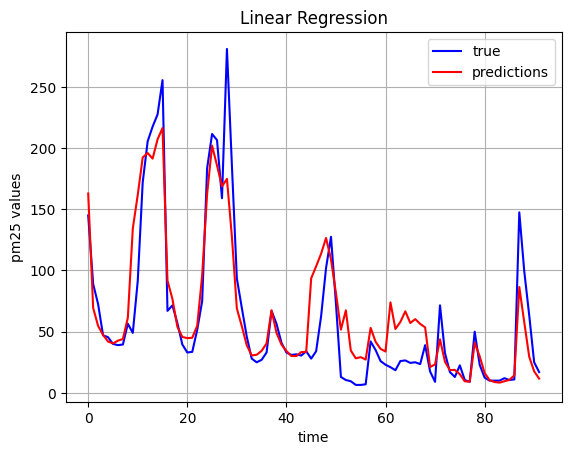

In [65]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title("Linear Regression")
plt.xlabel("time")
plt.ylabel('pm25 values')
plt.grid()
plt.legend()
plt.show()

### Ridge Regression

- r2 = 0.691(test)

In [68]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

test_sensor_index = np.random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)


scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 2
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


In [69]:
ridge_reg = linear_model.Ridge()
ridge_reg_params = {'alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}
rr_gs = model_selection.GridSearchCV(ridge_reg, param_grid=ridge_reg_params, cv=5)
rr_gs

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]})

In [70]:
rr_gs.fit(X_train, y_train)
print(rr_gs.score(X_train, y_train))

0.7469727005236307


In [71]:
rr_best = rr_gs.best_estimator_
rr_best

Ridge()

In [72]:
y_pred = rr_best.predict(X_test).reshape(-1)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2_score = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2_score = 0.7237582377996726
mse = 1098.172452827288


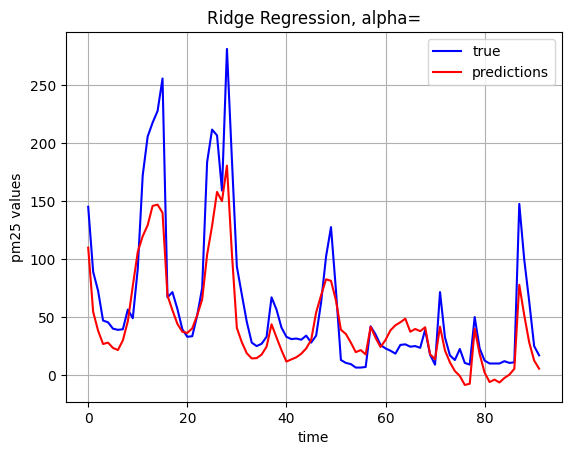

In [73]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title("Ridge Regression, alpha=")
plt.xlabel("time")
plt.ylabel('pm25 values')
plt.grid()
plt.legend()
plt.show()

### Lasso Regression

- r2 = 0.54(Test)

In [74]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

test_sensor_index = np.random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)


scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 8
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


In [75]:
lasso_reg = linear_model.Lasso()
param_grid = {'alpha': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}
lasso_reg_cv = model_selection.GridSearchCV(lasso_reg, param_grid=param_grid, cv=5)
lasso_reg_cv.fit(X_train, y_train)
print(lasso_reg_cv.score(X_train, y_train))

0.7223888116811267


In [76]:
lr_best = lasso_reg_cv.best_estimator_
lasso_reg_cv.best_estimator_

Lasso(alpha=10.0)

In [77]:
y_pred = lr_best.predict(X_test).reshape(-1)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2_score = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2_score = 0.7516108327969111
mse = 987.4471507509821


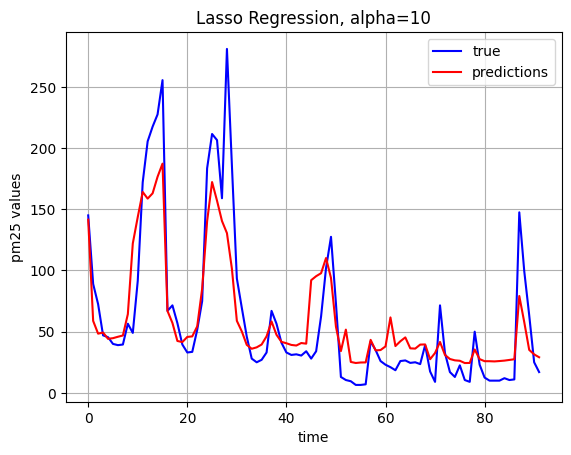

In [78]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title("Lasso Regression, alpha=10")
plt.xlabel("time")
plt.ylabel('pm25 values')
plt.grid()
plt.legend()
plt.show()

### Elastic Net 

- r2 = 0.685(Test)

In [79]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

test_sensor_index = np.random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)


scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 7
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


In [80]:
enet = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.5)
param_grid = {'alpha': [1e-1, 1, 1e1], 'l1_ratio': [0.25, 0.50, 0.75]}
enet_cv = model_selection.GridSearchCV(enet, param_grid=param_grid, cv=5)
enet_cv.fit(X_train, y_train)
enet_cv.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.75)

In [81]:
enet_best = enet_cv.best_estimator_
print(enet_best.score(X_train, y_train))

0.7471903355536922


In [82]:
y_pred = enet_best.predict(X_test).reshape(-1)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2_score = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2_score = 0.5207318475823033
mse = 1905.284263719922


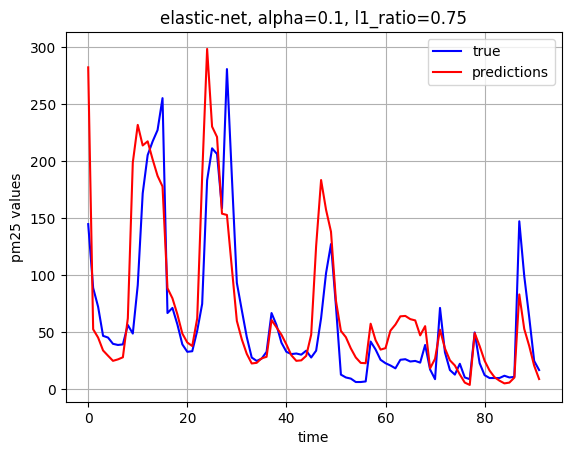

In [83]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title(f"elastic-net, alpha={enet_best.get_params()['alpha']}, l1_ratio={enet_best.get_params()['l1_ratio']}")
plt.xlabel("time")
plt.ylabel('pm25 values')
plt.grid()
plt.legend()
plt.show()

### RandomForestRegressor
- r2(test) = 0.83

In [84]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

test_sensor_index = np.random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)


scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 2
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


In [85]:
rf = ensemble.RandomForestRegressor()
param = {'n_estimators': np.arange(8, 32)}
rf_gs = model_selection.GridSearchCV(rf, param_grid=param, cv=5)
rf_gs.fit(X_train, y_train)
print(f"rf_gs training scores = {rf_gs.score(X_train, y_train)}")

rf_gs training scores = 0.9807126461913543


In [86]:
rf_best = rf_gs.best_estimator_
rf_best

RandomForestRegressor(n_estimators=23)

In [87]:
y_pred = rf_best.predict(X_test)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2 score = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2 score = 0.9778691280906773
mse = 87.97914440700255


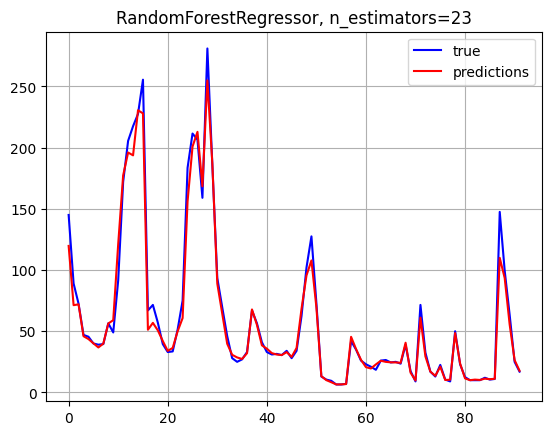

In [88]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title(f"RandomForestRegressor, n_estimators={rf_best.get_params()['n_estimators']}")
plt.grid()
plt.legend()
plt.show()

### GradientBoostRegressor
- r2(test) = 0.89

In [92]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

test_sensor_index = np.random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)


scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 5
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


In [93]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5],
    'min_samples_split': [5],
    "loss": ['squared_error']
}

gbr = ensemble.GradientBoostingRegressor()
gbr_cv = model_selection.GridSearchCV(gbr, param_grid=param_grid, cv=5)
gbr_cv.fit(X_train, y_train)
print(f"train r2 score = {gbr_cv.score(X_train, y_train)}")

train r2 score = 0.912537032381519


In [94]:
gbr_best = gbr_cv.best_estimator_
gbr_best

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=5,
                          n_estimators=300)

In [95]:
y_pred = gbr_best.predict(X_test)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2 score = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2 score = 0.8840462663879798
mse = 460.9628719456644


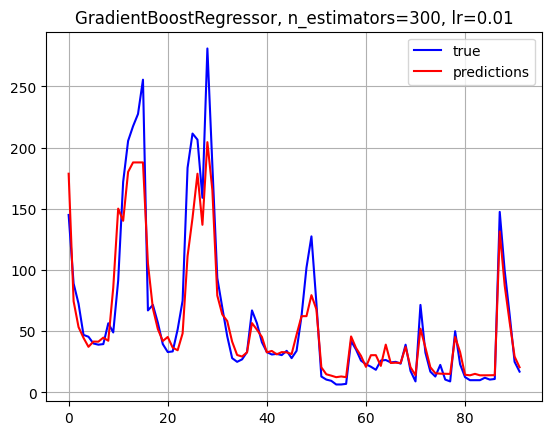

In [96]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title(f"GradientBoostRegressor, n_estimators={gbr_best.get_params()['n_estimators']}, lr={gbr_best.get_params()['learning_rate']}")
plt.grid()
plt.legend()
plt.show()

### Gaussian Process Regression

In [97]:
num_rows, num_columns = final_dict[pm25_name_dict[0]]['2023-01-05 13:00:00']['X'].shape
print(f"num_rows = {num_rows}, num_columns = {num_columns}")
X_train, X_test = np.empty((0, num_columns), dtype=np.float32), np.empty((0, num_columns), dtype=np.float32)
y_train, y_test = np.empty((0, 1), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

test_sensor_index = np.random.randint(0, len(pm25_name_dict))
print(f"test_sensor_index = {test_sensor_index}")

for key in final_dict[pm25_name_dict[0]].keys():
    # looping over time

    Xtrain = final_dict[pm25_name_dict[0]][key]['X'].loc[final_dict[pm25_name_dict[0]][key]['X'].index != pm25_name_dict[test_sensor_index]].values
    Xtest = final_dict[pm25_name_dict[0]][key]['X'].iloc[test_sensor_index].values.reshape(1, -1)
    ytrain = final_dict[pm25_name_dict[0]][key]['y'].iloc[final_dict[pm25_name_dict[0]][key]['y'].index != test_sensor_index].values.reshape(-1, 1)
    ytest = final_dict[pm25_name_dict[0]][key]['y'].iloc[test_sensor_index].values.reshape(1, -1)
    
    X_train = np.concatenate((X_train, Xtrain), axis=0)
    X_test = np.concatenate((X_test, Xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)


scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

num_rows = 13, num_columns = 6
test_sensor_index = 4
X_train.shape = (1104, 6), y_train.shape = (1104, 1)
X_test.shape = (92, 6), y_test.shape = (92, 1)


In [98]:
kernel = 1 * gaussian_process.kernels.RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
gpr = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train)
print(f"train r2 score = {gpr.score(X_train, y_train)}")
gpr.kernel_

train r2 score = 1.0


87.7**2 * RBF(length_scale=0.01)

In [99]:
y_pred = gpr.predict(X_test)
print(f"y_pred.shape = {y_pred.shape}")

print(f"r2 score = {metrics.r2_score(y_test, y_pred)}")
print(f"mse = {metrics.mean_squared_error(y_test, y_pred)}")

y_pred.shape = (92,)
r2 score = 1.0
mse = 1.2602641091008807e-24


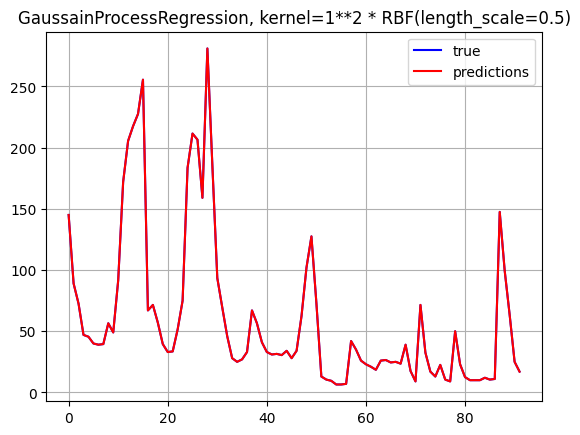

In [100]:
# let's plot the predictions and the true values

x = np.arange(len(y_pred))
plt.plot(x, y_test.reshape(-1), color='blue', label='true')
plt.plot(x, y_pred, color='red', label='predictions')
plt.title(f"GaussainProcessRegression, kernel={gpr.get_params()['kernel']}")
plt.grid()
plt.legend()
plt.show()

In [101]:
kernels = [
    (gaussian_process.kernels.RBF(), {'kernel__length_scale': [0.1, 0.5, 1.0]}),
    (gaussian_process.kernels.Matern(), {'kernel__length_scale': [0.1, 0.5, 1.0], 'kernel__nu': [1.5, 2.5]})
]

# Perform grid search for each kernel
for kernel, param_grid in kernels:
    # Create the GaussianProcessRegressor model
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel)

    # Create the GridSearchCV object
    grid_search = model_selection.GridSearchCV(model, param_grid, cv=5)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding score
    print("Kernel:", kernel)
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)
    print("----------------------------------")

    best_model = grid_search.best_estimator_

    # # Plot the fitted curve
    y_pred, y_std = best_model.predict(X_test, return_std=True)
    print(f"test r2 score = {metrics.r2_score(y_test, y_pred)}")

Kernel: RBF(length_scale=1)
Best Hyperparameters:  {'kernel__length_scale': 0.5}
Best Score:  -0.27260853499994414
----------------------------------
test r2 score = 1.0
Kernel: Matern(length_scale=1, nu=1.5)
Best Hyperparameters:  {'kernel__length_scale': 0.1, 'kernel__nu': 1.5}
Best Score:  0.3194630755010928
----------------------------------
test r2 score = 1.0


Kernel: RationalQuadratic(alpha=0.354, length_scale=0.209)
train r2 score:  1.0
test r2 score = 1.0
----------------------------------


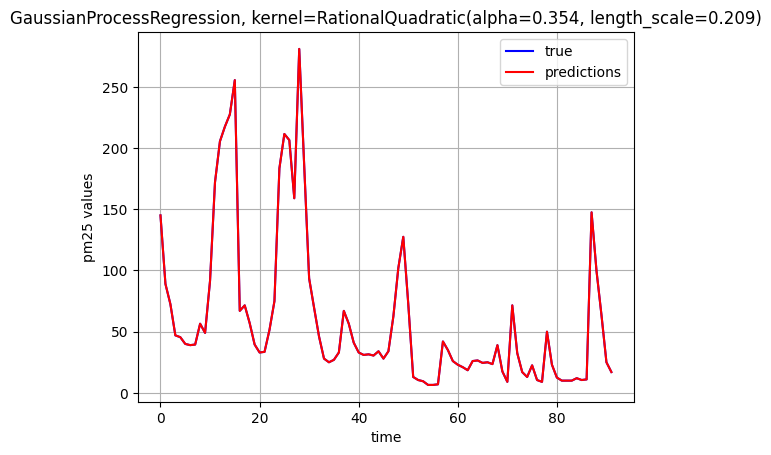

Kernel: DotProduct(sigma_0=1)
train r2 score:  0.7687565712847889
test r2 score = 0.8365474040527493
----------------------------------


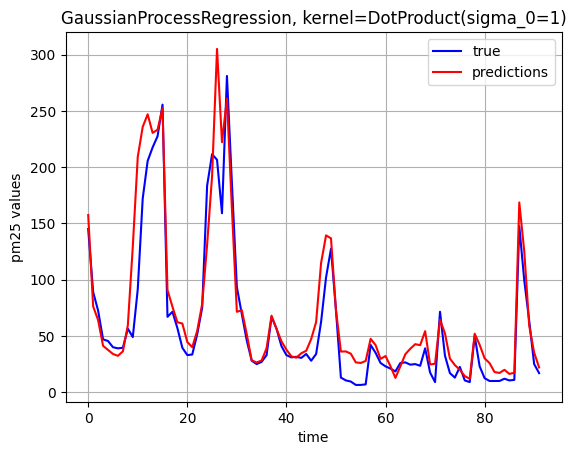

Kernel: WhiteKernel(noise_level=7.69e+03)
train r2 score:  -0.9348384875424929
test r2 score = -0.9348384875424935
----------------------------------


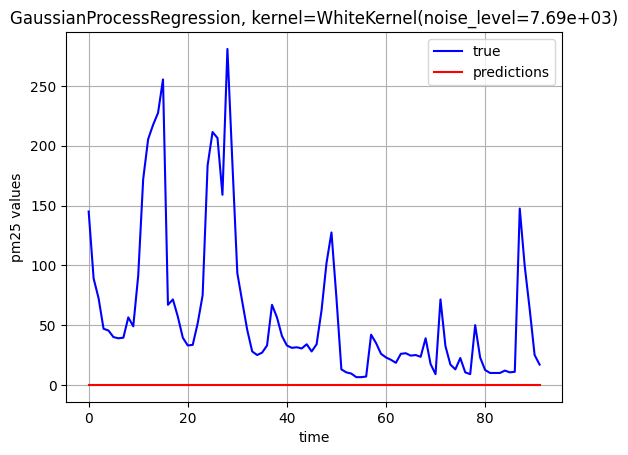

Kernel: 316**2
train r2 score:  -1496.9486043740771
test r2 score = -1496.9486043740776
----------------------------------


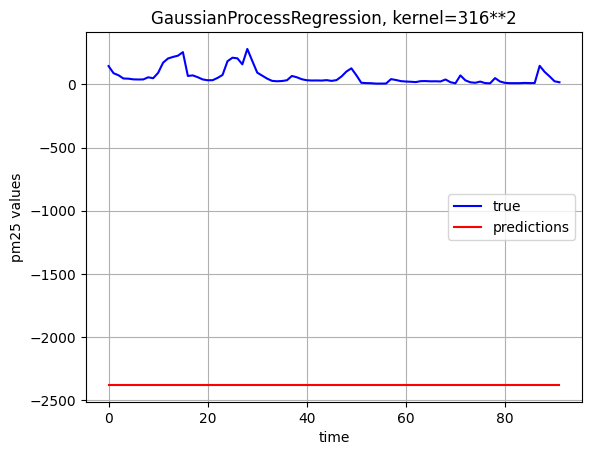

Kernel: PairwiseKernel(gamma=1.0, metric=linear)
train r2 score:  -0.16604237832929902
test r2 score = 0.2372809487428209
----------------------------------


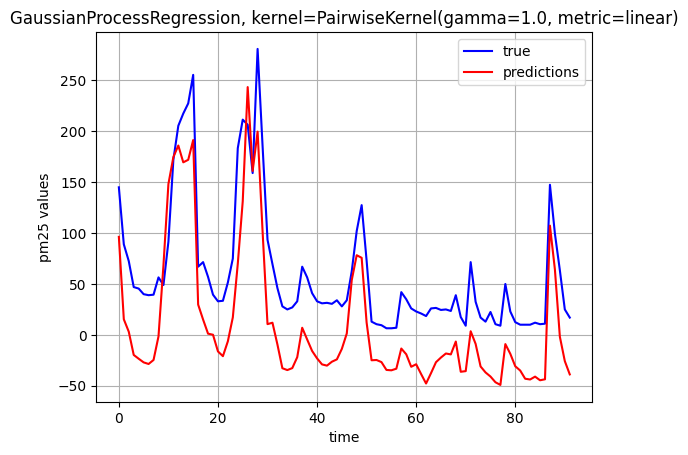

In [102]:
kernels = [
    gaussian_process.kernels.RationalQuadratic(length_scale=1.0, alpha=1.0),
    gaussian_process.kernels.DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5)),
    gaussian_process.kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5)),
    gaussian_process.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 1e5)),
    gaussian_process.kernels.PairwiseKernel(metric='linear')
]

for kernel in kernels:
    # Create the GaussianProcessRegressor model
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel)

    # Fit the GridSearchCV object to the data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    

    # Print the best hyperparameters and the corresponding score
    print("Kernel:", model.kernel_)
    print("train r2 score: ", model.score(X_train, y_train))
    print(f"test r2 score = {metrics.r2_score(y_test, y_pred)}")
    print("----------------------------------")

    # let's plot the predictions and the true values

    x = np.arange(len(y_pred))
    plt.figure()
    plt.plot(x, y_test.reshape(-1), color='blue', label='true')
    plt.plot(x, y_pred, color='red', label='predictions')
    plt.title(f"GaussianProcessRegression, kernel={model.kernel_}")
    plt.xlabel("time")
    plt.ylabel('pm25 values')
    plt.grid()
    plt.legend()
    plt.show()